# Assignment 2 - Image Segmentation
Dataset: [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/data) </br>

Sources:
- [Tensorflow](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb#scrollTo=39fYScNz9lmo)
- [Github UNet](https://github.com/alnbvy/OxfordPets_Unet)
- [Github RF](https://github.com/limalkasadith/OxfordIIITPet-classification/blob/main/kNN%20Classification.ipynb)


## U-Net

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-rluxdvxi
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-rluxdvxi
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=daae3279bab3e0bbb825d1cd6f1e46a6b77092f0cae7a87e4674a5ebd6b9d965
  Stored in directory: /tmp/pip-ephem-wheel-cache-od32qnin/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [2]:
# Imports

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [3]:
# Download Dataset

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePW2HV2/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePW2HV2/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


### Preprocessing

In [4]:
# Normalize image to a range of [0,1]
# Segmentation mask:  {1, 2, 3} -> {0, 1, 2}

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [5]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
# Split Images

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

### Augmentation

In [8]:
# Augment Data

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

### Input Pipeline

In [9]:
# Build Input Pipeline

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

### Visualization

In [10]:
# Visualize Images

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

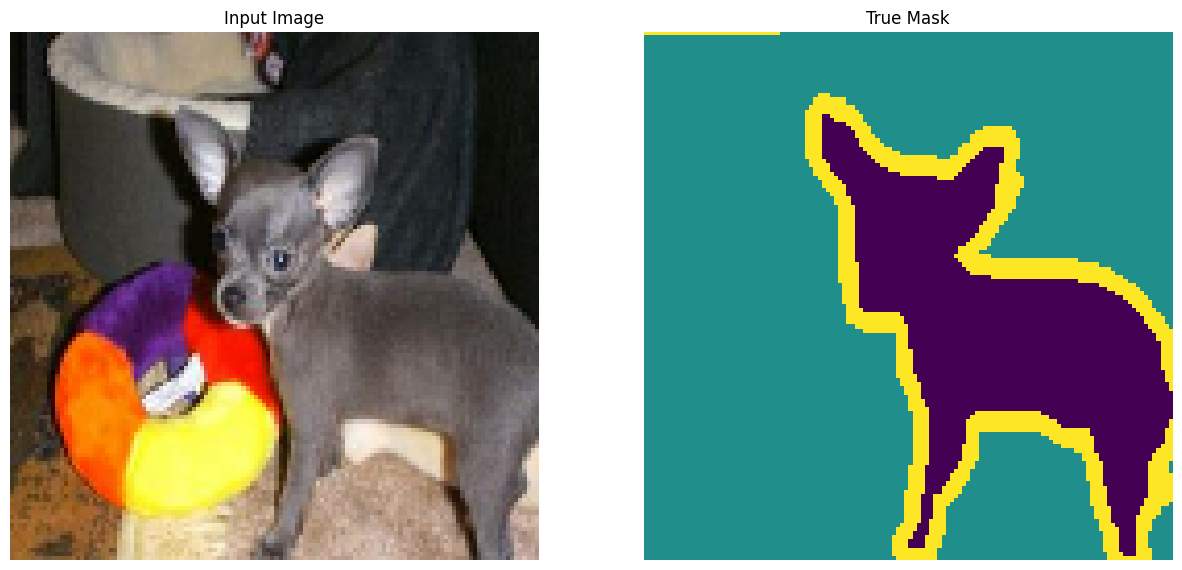

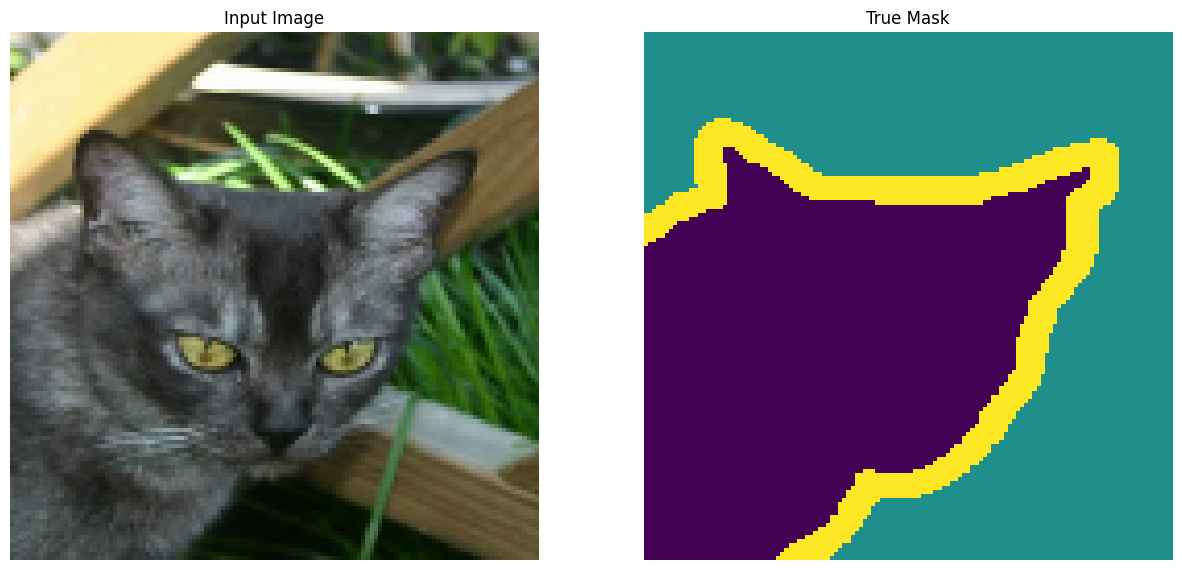

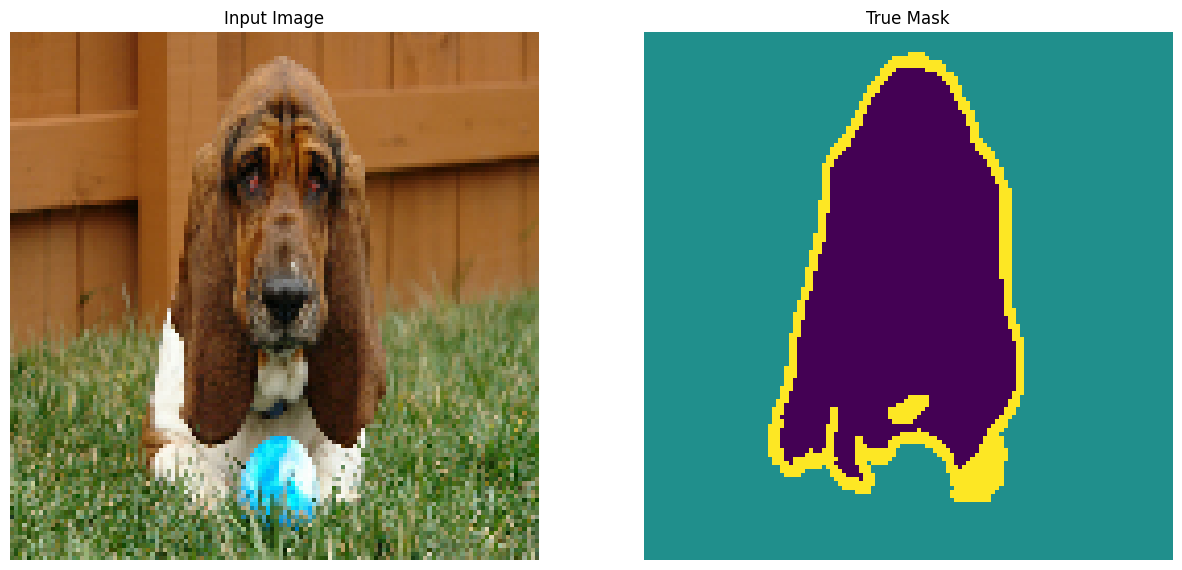

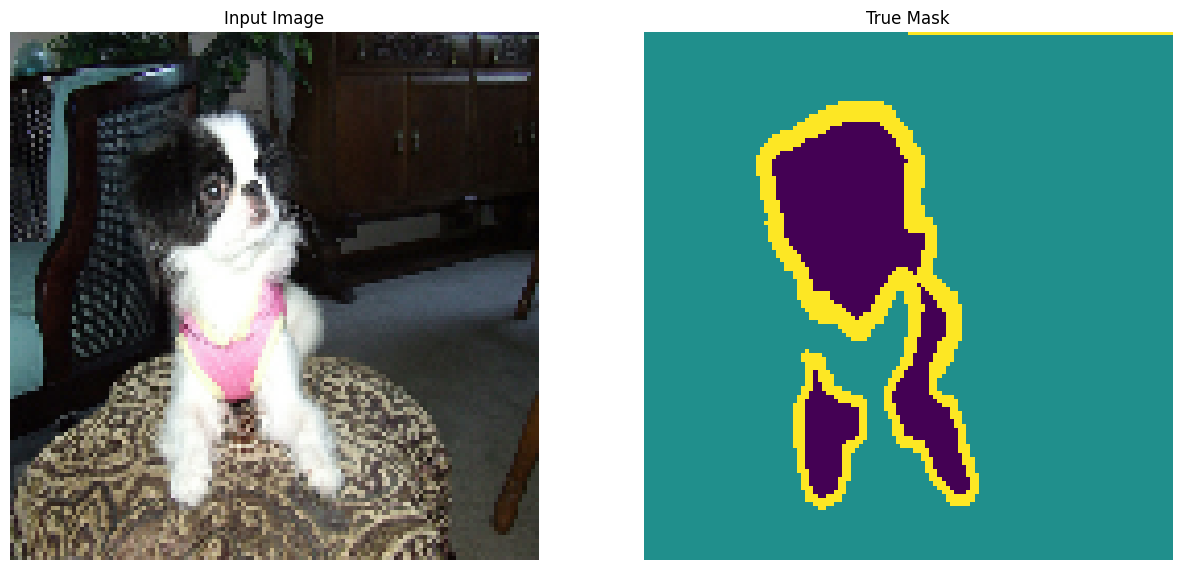

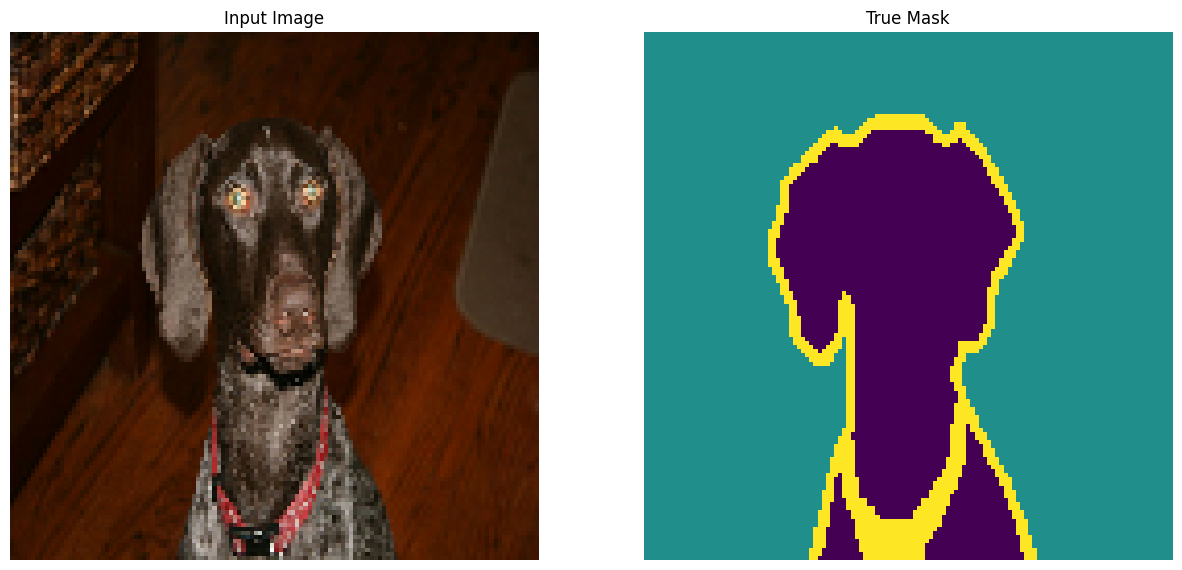

In [11]:
for images, masks in train_batches.take(5):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

### Model

In [12]:
# Define Encoder

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [13]:
# Define Decoder

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [14]:
# Define U-Net

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Training

In [15]:
# Train Model

OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

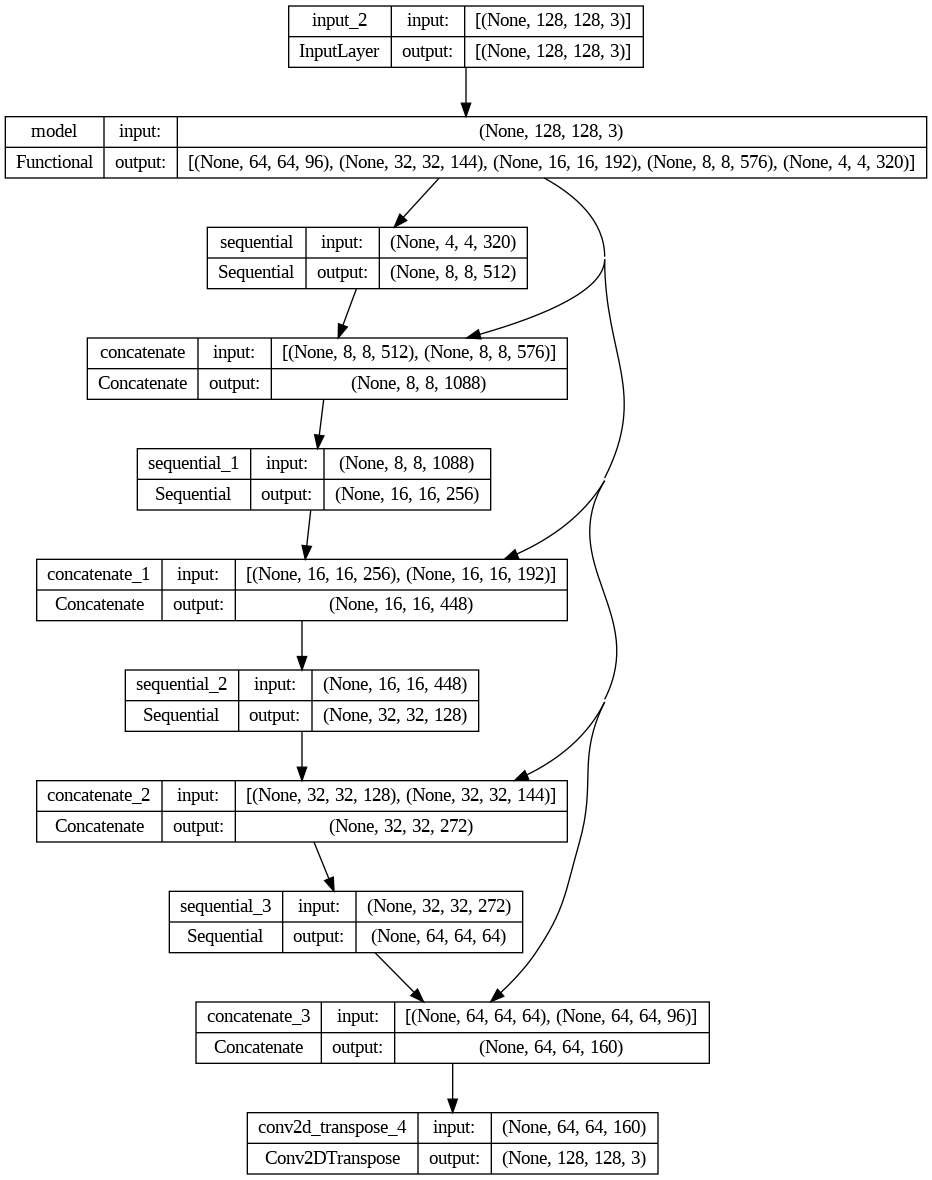

In [16]:
# Plot Architecture

tf.keras.utils.plot_model(model, show_shapes=True)

### Predictions

In [17]:
# Check predictions

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [18]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 3s 3s/step


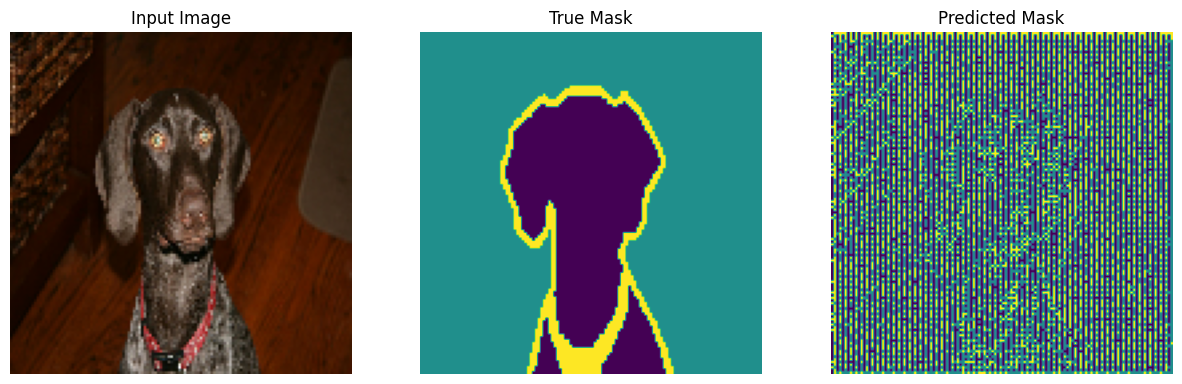

In [19]:
show_predictions()

In [20]:
# Observe how model improves during training

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 68ms/step


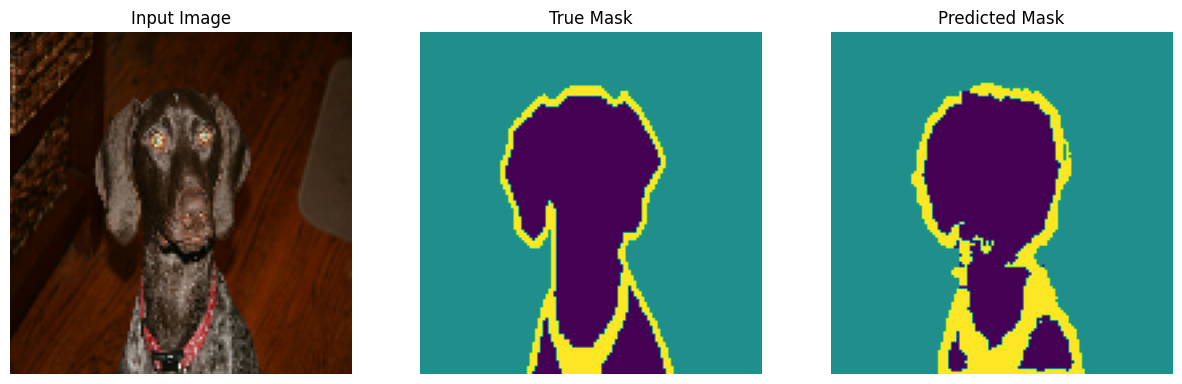


Sample Prediction after epoch 20

57/57 [==============================] - 348s 6s/step - loss: 0.1724 - accuracy: 0.9298 - val_loss: 0.2680 - val_accuracy: 0.9024


In [21]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

## Evaluation

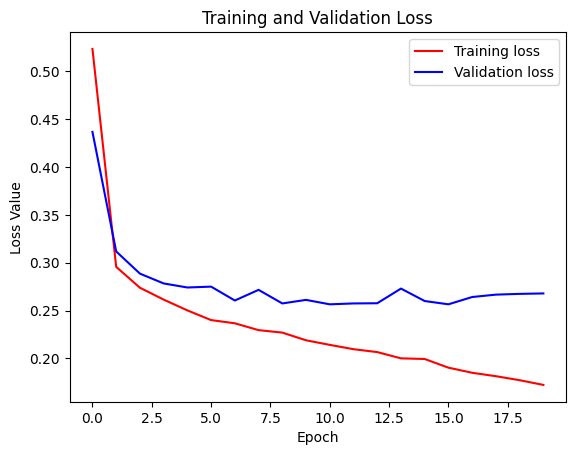

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

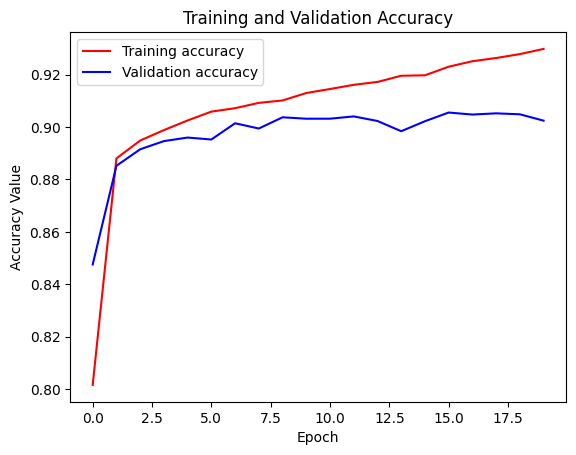

In [23]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, acc, 'r', label='Training accuracy')
plt.plot(model_history.epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

In [30]:
import numpy as np

# Sort the epochs based on validation accuracy
sorted_indices = np.argsort(acc)

# Get the indices of the 3 best and 3 worst epochs
best_indices = sorted_indices[-3:]
worst_indices = sorted_indices[:3]

# Display the corresponding metrics for these epochs
for idx in best_indices:
    print("Best Epoch:", idx)
    print("Accuracy:", acc[idx])

print('\n')

for idx in worst_indices:
    print("Worst Epoch:", idx)
    print("Accuracy:", acc[idx])

Best Epoch: 17
Accuracy: 0.9262927770614624
Best Epoch: 18
Accuracy: 0.9277884364128113
Best Epoch: 19
Accuracy: 0.9297621846199036


Worst Epoch: 0
Accuracy: 0.8015937209129333
Worst Epoch: 1
Accuracy: 0.8879909515380859
Worst Epoch: 2
Accuracy: 0.8948050737380981


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as T

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# train_split
raw_train_dataset = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', download=True)

# test_split
raw_test_dataset = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', split='test', download=True)


100%|██████████| 791918971/791918971 [01:25<00:00, 9281142.02it/s]


Extracting data/oxford-pets/oxford-iiit-pet/images.tar.gz to data/oxford-pets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7414664.65it/s] 


Extracting data/oxford-pets/oxford-iiit-pet/annotations.tar.gz to data/oxford-pets/oxford-iiit-pet


In [ ]:
class preprocessDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, target = self.dataset[index]
        augmented_image = self.transform(image)
        return augmented_image, target

In [ ]:
# Pretrained weights that going to load to the model
weights = torchvision.models.resnet.ResNet34_Weights.DEFAULT

# Requiered preprocessing for the R50 model from torchvision
ResNet_preprocess = weights.transforms()

In [ ]:
# Preprocessed datasets

train_dataset = preprocessDataset(raw_train_dataset, ResNet_preprocess)
test_dataset = preprocessDataset(raw_test_dataset, ResNet_preprocess)

In [ ]:
# Dataloaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Model class

class R50_encoder(torch.nn.Module):
    def __init__(self,weights, freeze_weights):
        super(R50_encoder, self).__init__()

        # Load the ResNet50 model
        self.resnet = torchvision.models.resnet34(weights=weights)

        # Freezing the weights of the encoder
        if freeze_weights:
            for param in self.resnet.parameters():
                param.requires_grad = False

        # Remove the last linear layer
        self.layers = torch.nn.Sequential(*list(self.resnet.children())[:-1])


    def forward(self, x):
        outputs = self.layers(x)
        return outputs

In [ ]:
def get_features(encoder,dataloader, device):
    features_arr =[]
    labels_arr = []

    # switch to the evaluation mode
    encoder.eval()

    for images, labels in tqdm(dataloader):
            # load the images to GPU
            images = images.to(device)

            features = encoder(images)
            features = features.view(features.shape[0],-1).detach().cpu().numpy()

            features_arr.append(features)
            labels_arr.append(labels)

    # combine batches
    features_arr = np.concatenate(features_arr, axis=0)
    labels_arr = np.concatenate(labels_arr, axis=0)

    return features_arr, labels_arr

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = R50_encoder(weights = weights, freeze_weights=True)
encoder = encoder.to(torch.float32)
encoder = encoder.to(device)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 107MB/s]


In [ ]:
# Get the features of the train and test images

x_train,y_train = get_features(encoder,train_loader, device)
x_test, y_test = get_features(encoder,test_loader, device)

100%|██████████| 58/58 [10:22<00:00, 10.73s/it]


In [ ]:
# Create model
rf = RandomForestClassifier(n_estimators=10)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10)

In [ ]:
# Predictions
y_pred_train = rf.predict(x_train)
y_pred_test = rf. predict(x_test)

Training Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       0.97      1.00      0.99       100
           6       0.98      1.00      0.99       100
           7       1.00      1.00      1.00        96
           8       0.99      1.00      1.00       100
           9       1.00      1.00      1.00       100
          10       1.00      1.00      1.00       100
          11       1.00      0.97      0.98        93
          12       1.00      0.99      0.99        96
          13       0.99      1.00      1.00       100
          14       1.00      1.00      1.00       100
          15       1.00      1.00      1.00       100
          16       1.00      1.00      1.00       100
          17 

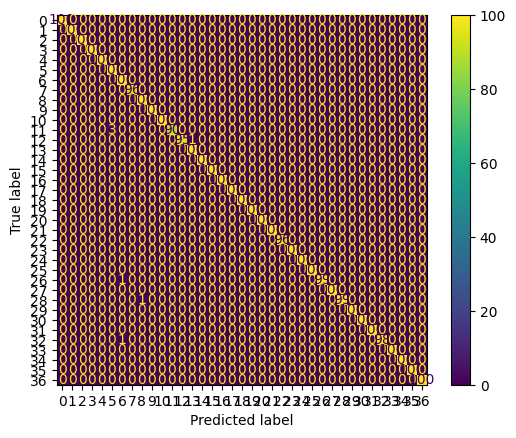

In [ ]:
# Metrics
print('Training Data')
print(classification_report(y_train, y_pred_train))
cm_train = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.show()

Testing Data
              precision    recall  f1-score   support

           0       0.53      0.73      0.62        98
           1       0.56      0.64      0.60       100
           2       0.53      0.52      0.53       100
           3       0.81      0.87      0.84       100
           4       0.85      0.88      0.86       100
           5       0.52      0.68      0.59       100
           6       0.62      0.78      0.69       100
           7       0.72      0.76      0.74        88
           8       0.72      0.80      0.76        99
           9       0.62      0.55      0.59       100
          10       0.81      0.91      0.86       100
          11       0.71      0.72      0.72        97
          12       0.82      0.94      0.87       100
          13       0.87      0.81      0.84       100
          14       0.86      0.88      0.87       100
          15       0.92      0.94      0.93       100
          16       0.82      0.88      0.85       100
          17  

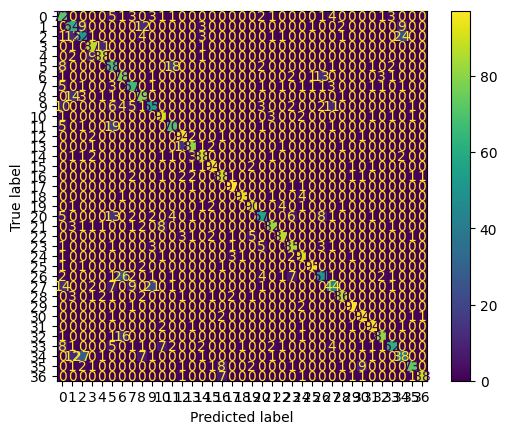

In [ ]:
print('Testing Data')
print(classification_report(y_test, y_pred_test))
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.show()